In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob

In [2]:
# device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
"""# Step 1: Get a list of all CSV file paths in the directory
data_path = glob.glob("D:\PythonProjs\CLARAi\Data\*.csv")  # Modify with your directory path
label_path = glob.glob("D:\PythonProjs\CLARAi\Label\*.csv")

# Step 2: Read each CSV file and store in a list of DataFrames
datadfs = [pd.read_csv(file) for file in data_path]
labeldfs = [pd.read_csv(file) for file in label_path]

# Step 3: Concatenate all DataFrames into one
final_data_df = pd.concat(datadfs, ignore_index=True)
final_label_df = pd.concat(labeldfs, ignore_index=True)"""

'# Step 1: Get a list of all CSV file paths in the directory\ndata_path = glob.glob("D:\\PythonProjs\\CLARAi\\Data\\*.csv")  # Modify with your directory path\nlabel_path = glob.glob("D:\\PythonProjs\\CLARAi\\Label\\*.csv")\n\n# Step 2: Read each CSV file and store in a list of DataFrames\ndatadfs = [pd.read_csv(file) for file in data_path]\nlabeldfs = [pd.read_csv(file) for file in label_path]\n\n# Step 3: Concatenate all DataFrames into one\nfinal_data_df = pd.concat(datadfs, ignore_index=True)\nfinal_label_df = pd.concat(labeldfs, ignore_index=True)'

In [4]:
class CONFIG:
    seq_len = 128
    num_seq = 500
    data_ch = 36
    hidden_size = 32  # Hidden state size of the GRU
    output_size = 1  # Binary classification
    num_layers = 6  # Number of GRU layers
    learning_rate = 0.001
    num_epochs = 250
    batch_size = 8

In [5]:
def data_gen(data_path, label_path):
    final_data_df = pd.read_csv(data_path)
    final_label_df = pd.read_csv(label_path)

    train_labels_flat = final_label_df.values.flatten()
    
    # Compute class weights (inverse of class frequencies)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Parameters
    sequence_length = CONFIG.seq_len  # Length of each subsequence
    num_subsequences = CONFIG.num_seq  # Number of subsequences to extract

    # Get possible starting indices, ensuring there's enough space for a full subsequence
    possible_starts = np.arange(0, len(final_data_df) - sequence_length + 1)
    np.random.shuffle(possible_starts)

    # Select the first `num_subsequences` starting indices
    selected_starts = possible_starts[:num_subsequences]

    # Create a list to hold the subsequences
    subsequences = [final_data_df.iloc[start:start + sequence_length].values for start in selected_starts]
    sublabels = [final_label_df.iloc[start:start + sequence_length].values for start in selected_starts]

    # Convert subsequences list to a NumPy array
    subsequences_array = np.array(subsequences)
    sublabels_array = np.array(sublabels)

    # subsequences_array will have shape (num_subsequences, sequence_length, num_channels)
    # print(subsequences_array.shape)  # Should print (100, 100, 36)
    # print(sublabels_array.shape)

    return torch.from_numpy(subsequences_array), torch.from_numpy(sublabels_array), class_weights


In [6]:

# Sample time series data with shape (batch_size, sequence_length, num_features)
# neuroimaging_data: Time series data from multiple neuroimaging channels
# labels: Binary labels (0 = no pain, 1 = pain) for each time step
# Assume neuroimaging_data is a numpy array of shape (num_samples, sequence_length, num_channels)
# labels is a numpy array of shape (num_samples, sequence_length)

class BidirectionalLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BidirectionalLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Adjust the fully connected layer to account for doubled hidden size (forward + backward)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)  # Adjust Batch Normalization for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state and cell state with zeros for both directions
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply batch normalization
        # Permute to (batch_size, hidden_size*2, sequence_length) for batch norm
        out = out.permute(0, 2, 1)
        out = self.batch_norm(out)
        
        # Permute back to (batch_size, sequence_length, hidden_size*2)
        out = out.permute(0, 2, 1)
        
        # Apply the linear layer to each time step
        out = self.fc(out)
        
        return self.sigmoid(out)


In [7]:
# data_path = glob.glob("D:\PythonProjs\CLARAi\Data_train\*.csv")  # Modify with your directory path
# label_path = glob.glob("D:\PythonProjs\CLARAi\Label_train\*.csv")

# data_path = glob.glob("/home/frank/Documents/CLARAi/Data/*.csv")  # Modify with your directory path
# label_path = glob.glob("/home/frank/Documents/CLARAi/Label/*.csv")

# data_path = glob.glob("/Users/xiaosuhu/Documents/Python/CLARAi/Data/*.csv")  # Modify with your directory path
# label_path = glob.glob("/Users/xiaosuhu/Documents/Python/CLARAi/Data/*.csv")

data_path = glob.glob("/kaggle/input/CLARAi/Data_train/*.csv")  # Modify with your directory path
label_path = glob.glob("/kaggle/input/CLARAi/Label_train/*.csv")

# Sort the lists
data_path = sorted(data_path)
label_path = sorted(label_path)


In [8]:
data_path

['/kaggle/input/CLARAi/Data_train/data1.csv',
 '/kaggle/input/CLARAi/Data_train/data10.csv',
 '/kaggle/input/CLARAi/Data_train/data11.csv',
 '/kaggle/input/CLARAi/Data_train/data12.csv',
 '/kaggle/input/CLARAi/Data_train/data13.csv',
 '/kaggle/input/CLARAi/Data_train/data16.csv',
 '/kaggle/input/CLARAi/Data_train/data17.csv',
 '/kaggle/input/CLARAi/Data_train/data3.csv',
 '/kaggle/input/CLARAi/Data_train/data4.csv',
 '/kaggle/input/CLARAi/Data_train/data5.csv',
 '/kaggle/input/CLARAi/Data_train/data6.csv',
 '/kaggle/input/CLARAi/Data_train/data7.csv',
 '/kaggle/input/CLARAi/Data_train/data8.csv',
 '/kaggle/input/CLARAi/Data_train/data9.csv']

In [9]:

# data_path = "D:\PythonProjs\CLARAi\Data\data1.csv"
# label_path = "D:\PythonProjs\CLARAi\Label\label1.csv"
neuroimaging_data = torch.empty(0,CONFIG.seq_len,CONFIG.data_ch)
labels = torch.empty(0,CONFIG.seq_len,1)
class_weights = torch.Tensor([0., 0.])

In [10]:

for datapath, labelpath in zip(data_path, label_path):
    print(f'datapath: {datapath}')
    print(f'labelpath: {labelpath}')    
    data, label, weight = data_gen(datapath, labelpath)
    print(f'Data shape: {data.shape}, Label shape: {label.shape}, Weight shape: {weight.shape}')
    neuroimaging_data= torch.cat([neuroimaging_data, data])
    labels = torch.cat([labels, label])
    class_weights += weight

normalized_weights = class_weights / class_weights.sum()


datapath: /kaggle/input/CLARAi/Data_train/data1.csv
labelpath: /kaggle/input/CLARAi/Label_train/label1.csv
Data shape: torch.Size([500, 128, 36]), Label shape: torch.Size([500, 128, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/CLARAi/Data_train/data10.csv
labelpath: /kaggle/input/CLARAi/Label_train/label10.csv
Data shape: torch.Size([500, 128, 36]), Label shape: torch.Size([500, 128, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/CLARAi/Data_train/data11.csv
labelpath: /kaggle/input/CLARAi/Label_train/label11.csv
Data shape: torch.Size([500, 128, 36]), Label shape: torch.Size([500, 128, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/CLARAi/Data_train/data12.csv
labelpath: /kaggle/input/CLARAi/Label_train/label12.csv
Data shape: torch.Size([500, 128, 36]), Label shape: torch.Size([500, 128, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/CLARAi/Data_train/data13.csv
labelpath: /kaggle/input/CLARAi/Label_train/label13.csv
Data shape: torch

In [11]:
neuroimaging_data.shape, labels.shape

(torch.Size([7000, 128, 36]), torch.Size([7000, 128, 1]))

In [12]:
# Count the number of 1s
num_zeros = torch.sum(labels == 0).item()
num_ones = torch.sum(labels == 1).item()

print(f"Number of 0s: {num_zeros}Number of 1s: {num_ones} Ratio is {num_ones/(num_ones + num_zeros)}")

Number of 0s: 685607Number of 1s: 210393 Ratio is 0.23481361607142856


In [13]:
# Hyperparameters
input_size = CONFIG.data_ch  # Number of features (channels)
hidden_size = CONFIG.hidden_size  # Hidden state size of the GRU
output_size = CONFIG.output_size  # Binary classification
num_layers = CONFIG.num_layers  # Number of GRU layers
learning_rate = CONFIG.learning_rate
num_epochs = CONFIG.num_epochs
batch_size = CONFIG.batch_size

# Preprocessing (e.g., normalization)
# scaler = StandardScaler()
# neuroimaging_data = scaler.fit_transform(neuroimaging_data.reshape(-1, input_size)).reshape(neuroimaging_data.shape)

# Convert numpy arrays to PyTorch tensors
train_data, test_data, train_labels, test_labels = train_test_split(neuroimaging_data, labels, test_size=0.2, random_state=42)
train_data, test_data = torch.tensor(train_data, dtype=torch.float32).to(device), torch.tensor(test_data, dtype=torch.float32).to(device)
train_labels, test_labels = torch.tensor(train_labels, dtype=torch.float32).to(device), torch.tensor(test_labels, dtype=torch.float32).to(device)

# Create GRU model
model = BidirectionalLSTMClassifier(input_size, hidden_size, output_size, num_layers)
model = torch.nn.DataParallel(model)
model.to(device)

# Loss and optimizer
# criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification


# Convert the class weights to a tensor and move to the appropriate device
class_weights = class_weights.to(device)

# Use BCEWithLogitsLoss, which combines sigmoid activation and binary cross-entropy loss
criterion = nn.BCEWithLogitsLoss(pos_weight=normalized_weights[0])  # pos_weight applies only to class 1

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

/tmp/ipykernel_24/3072856817.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data, test_data = torch.tensor(train_data, dtype=torch.float32).to(device), torch.tensor(test_data, dtype=torch.float32).to(device)
/tmp/ipykernel_24/3072856817.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels, test_labels = torch.tensor(train_labels, dtype=torch.float32).to(device), torch.tensor(test_labels, dtype=torch.float32).to(device)


In [14]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()
    
    # Forward pass (training)
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)
    
    # Backward pass and optimization
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()

    # Validation phase (no gradient calculations)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_labels)

    # Update learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Print loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [5/250], Train Loss: 0.7520, Val Loss: 0.7650
Epoch [10/250], Train Loss: 0.6982, Val Loss: 0.7626
Epoch [15/250], Train Loss: 0.6671, Val Loss: 0.7691
Epoch [20/250], Train Loss: 0.6531, Val Loss: 0.7646
Epoch [25/250], Train Loss: 0.6422, Val Loss: 0.7518
Epoch [30/250], Train Loss: 0.6338, Val Loss: 0.7326
Epoch [35/250], Train Loss: 0.6262, Val Loss: 0.6952
Epoch [40/250], Train Loss: 0.6194, Val Loss: 0.6578
Epoch [45/250], Train Loss: 0.6134, Val Loss: 0.6307
Epoch [50/250], Train Loss: 0.6072, Val Loss: 0.6121
Epoch [55/250], Train Loss: 0.6022, Val Loss: 0.6045
Epoch [60/250], Train Loss: 0.5982, Val Loss: 0.5998
Epoch [65/250], Train Loss: 0.5951, Val Loss: 0.5968
Epoch [70/250], Train Loss: 0.5895, Val Loss: 0.5932
Epoch [75/250], Train Loss: 0.5879, Val Loss: 0.5917
Epoch [80/250], Train Loss: 0.5868, Val Loss: 0.5906
Epoch [85/250], Train Loss: 0.5856, Val Loss: 0.5899
Epoch [90/250], Train Loss: 0.5849, Val Loss: 0.5891
Epoch [95/250], Train Loss: 0.5844, Val Loss: 0

In [15]:
# After the training loop
# torch.save(model.state_dict(), 'D:\PythonProjs\CLARAi\Trained_model_weights\lstm_bidi_model_state_dict_data_300_ep_200.pth')
torch.save(model.state_dict(), '/kaggle/working/lstm_bidi_model_state_dict_data_300_ep_200.pth')
# print("Model state_dict saved to 'lstm_unidi_model_state_dict.pth'")

Accuracy: 90.61%
Confusion Matrix:
[[126954   9993]
 [  6838  35415]]


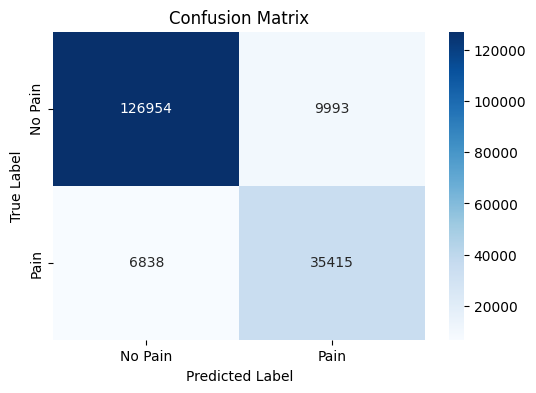

In [16]:

model.eval()
with torch.no_grad():
    test_outputs = model(test_data)
    predicted = (test_outputs > 0.5).float()  # Threshold at 0.5 for binary classification
    
    # Calculate accuracy
    accuracy = (predicted == test_labels).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')

    # Flatten the predicted and test labels for confusion matrix calculation
    predicted_flat = predicted.cpu().numpy().flatten()
    test_labels_flat = test_labels.cpu().numpy().flatten()

    # Generate the confusion matrix
    cm = confusion_matrix(test_labels_flat, predicted_flat)
    print(f'Confusion Matrix:\n{cm}')

    # Optional: plot the confusion matrix for visualization
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Pain', 'Pain'], yticklabels=['No Pain', 'Pain'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()


In [17]:
def plot_roc_auc(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        # Get the raw logits (before applying sigmoid)
        test_outputs = model(test_data)
        
        # Convert test_labels and test_outputs to NumPy arrays for sklearn
        test_labels_flat = test_labels.cpu().numpy().flatten()
        test_outputs_flat = test_outputs.cpu().numpy().flatten()

        # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
        fpr, tpr, thresholds = roc_curve(test_labels_flat, test_outputs_flat)
        
        # Calculate the AUC score
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()

    return roc_auc

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


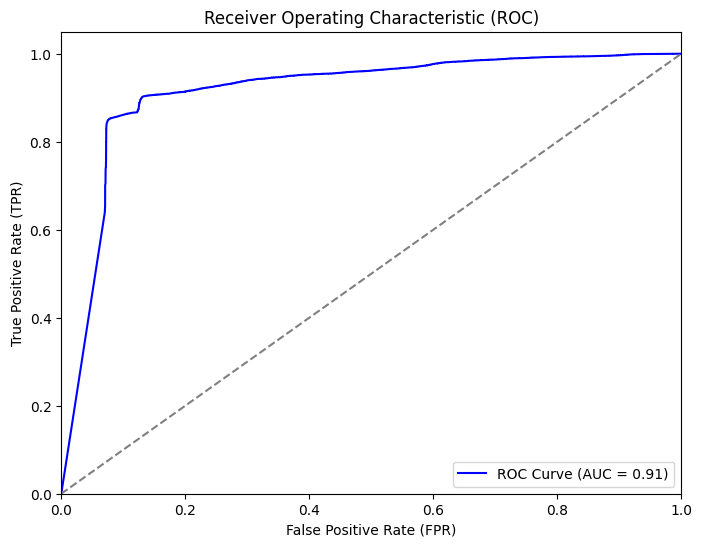

0.9137263761118852

In [18]:
plot_roc_auc(model, test_data, test_labels)

In [19]:
# Test data evaluation

# data_test = pd.read_csv('D:\PythonProjs\CLARAi\Data_test\data18.csv')
# label_test = pd.read_csv('D:\PythonProjs\CLARAi\Label_test\label18.csv')

data_test = pd.read_csv('/kaggle/input/CLARAi/Data_test/data18.csv')
label_test = pd.read_csv('/kaggle/input/CLARAi/Label_test/label18.csv')

data_test= data_test.to_numpy()
label_test = label_test.to_numpy()

sequence_length = CONFIG.seq_len
input_size = CONFIG.data_ch


# Calculate the number of complete sequences
num_sequences = data_test.shape[0] // sequence_length  # 5 sequences

# Truncate the data to have only complete sequences
truncated_data = data_test[:num_sequences * sequence_length]  # Shape: (1280, 36)

# Reshape to (num_sequences, sequence_length, input_size)
test_sequences = truncated_data.reshape(num_sequences, sequence_length, input_size)  # Shape: (5, 256, 36)

# Convert to PyTorch tensor
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)


In [20]:

# Create DataLoader
test_dataset = TensorDataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)  # Adjust batch_size as needed

# Perform inference
all_outputs = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)  # (batch_size, 256, 36)
        outputs = model(inputs)       # (batch_size, 256, 1)
        all_outputs.append(outputs.cpu().numpy())

# Concatenate all outputs
all_outputs = np.concatenate(all_outputs, axis=0)  # Shape: (6, 256, 1)

# Apply threshold to get binary predictions
predictions = (all_outputs >= 0.5).astype(int)  # Shape: (6, 256, 1)
predictions = predictions.squeeze(-1)           # Shape: (6, 256)
# Flatten the predictions
flattened_predictions = predictions.flatten()  # Shape: (1536,)

true_label = label_test[:num_sequences * sequence_length].squeeze(-1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Confusion Matrix:
[[853  56]
 [237   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       909
           1       0.10      0.02      0.04       243

    accuracy                           0.75      1152
   macro avg       0.44      0.48      0.45      1152
weighted avg       0.64      0.75      0.68      1152



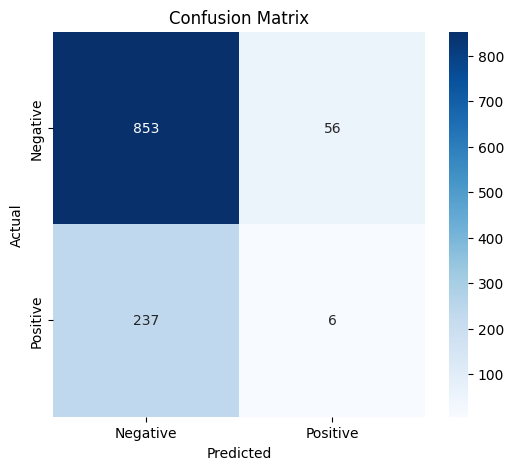

In [21]:
cm = confusion_matrix(true_label, flattened_predictions)
print("Confusion Matrix:")
print(cm)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(true_label, flattened_predictions))

# Optional: Visualize the confusion matrix
labels = ['Negative', 'Positive']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()